In [1]:
%load_ext autoreload

In [2]:
import os, sys, json, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
BASE_PATH = os.path.join(os.getcwd(), "..", "..")

METRICS_PATH = os.path.join(BASE_PATH, "metrics")
MODULES_PATH = os.path.join(BASE_PATH, "modules")

In [4]:
sys.path.append(MODULES_PATH)

In [5]:
from active_learning import ExperimentSuitMetrics
from utils import MetricsTransformer

In [6]:
%autoreload 2
metrics_handler = ExperimentSuitMetrics(os.path.join(METRICS_PATH, "y_gal_external"))
metrics_transformer = MetricsTransformer()

In [10]:
dtypes = {"iteration": int, "labeled_pool_size": int, "eval_time": float, "eval_accuracy": float, "train_time": float, "eval_loss": float}
df_random = metrics_transformer.load("0_mc_dropout_random", metrics_handler, dtype=dtypes)
df_max_entropy = metrics_transformer.load("0_mc_dropout_max_entropy", metrics_handler, dtype=dtypes)
df_bald = metrics_transformer.load("0_mc_dropout_bald", metrics_handler, dtype=dtypes)
df_max_var_ratio = metrics_transformer.load("0_mc_dropout_max_var_ratio", metrics_handler, dtype=dtypes)
df_std_mean = metrics_transformer.load("0_mc_dropout_std_mean", metrics_handler, dtype=dtypes)

## Methods

In [11]:
def get_losses(dataframe):
    """
        Returns list of losses during traing as a separate dataframe
    """
    return MetricsTransformer.list_to_series(dataframe, "train_loss")

In [12]:
def loss_in_steps(losses, step_size, num_plots, figsize=(22, 10), num_columns=5, from_epoch=None, to_epoch=None):
    
    
    num_rows = math.ceil(num_plots/num_columns)
    fig, axes = plt.subplots(num_rows, num_columns, figsize=figsize)    
    
    column_idx = 0
    range_start = 0
    row_idx = 0
    for i in range(num_plots):
        
        range_end = range_start + step_size
        
        data = losses.T[range_start:range_end].T
        
        if to_epoch is not None and from_epoch is not None:
            data = data[from_epoch:to_epoch]
        
        elif to_epoch is not None:
            data = data[:to_epoch]
        
        elif from_epoch is not None:
            data = data[from_epoch:]
        
        sns.lineplot(data=data, ax=axes[row_idx, column_idx])
        axes[row_idx, column_idx].set_ylabel("Loss")
        axes[row_idx, column_idx].set_xlabel("Epoch")
        axes[row_idx, column_idx].legend(title="Iteration")
        axes[row_idx, column_idx].set_xticks(range(0, len(data.T.columns), 3))
        
        
        # Update range of data to plot
        range_start += step_size
        column_idx += 1
        
        # Update row index
        if column_idx % num_columns == 0:
            row_idx += 1
            column_idx = 0

In [13]:
df_random.columns

Index(['train_loss', 'train_time', 'eval_loss', 'eval_accuracy', 'eval_time',
       'iteration', 'labeled_pool_size'],
      dtype='object')

In [14]:
def merge_and_exclude(dataframes, to_exclude=[]):
    
    filtered = []
    for frame in dataframes:
        all_columns = list(frame.columns)
        columns_filtered = list(filter(lambda name: name not in to_exclude, all_columns))
        filtered.append(frame[columns_filtered])

    return pd.concat(filtered, sort=True)

## Loss Comparison

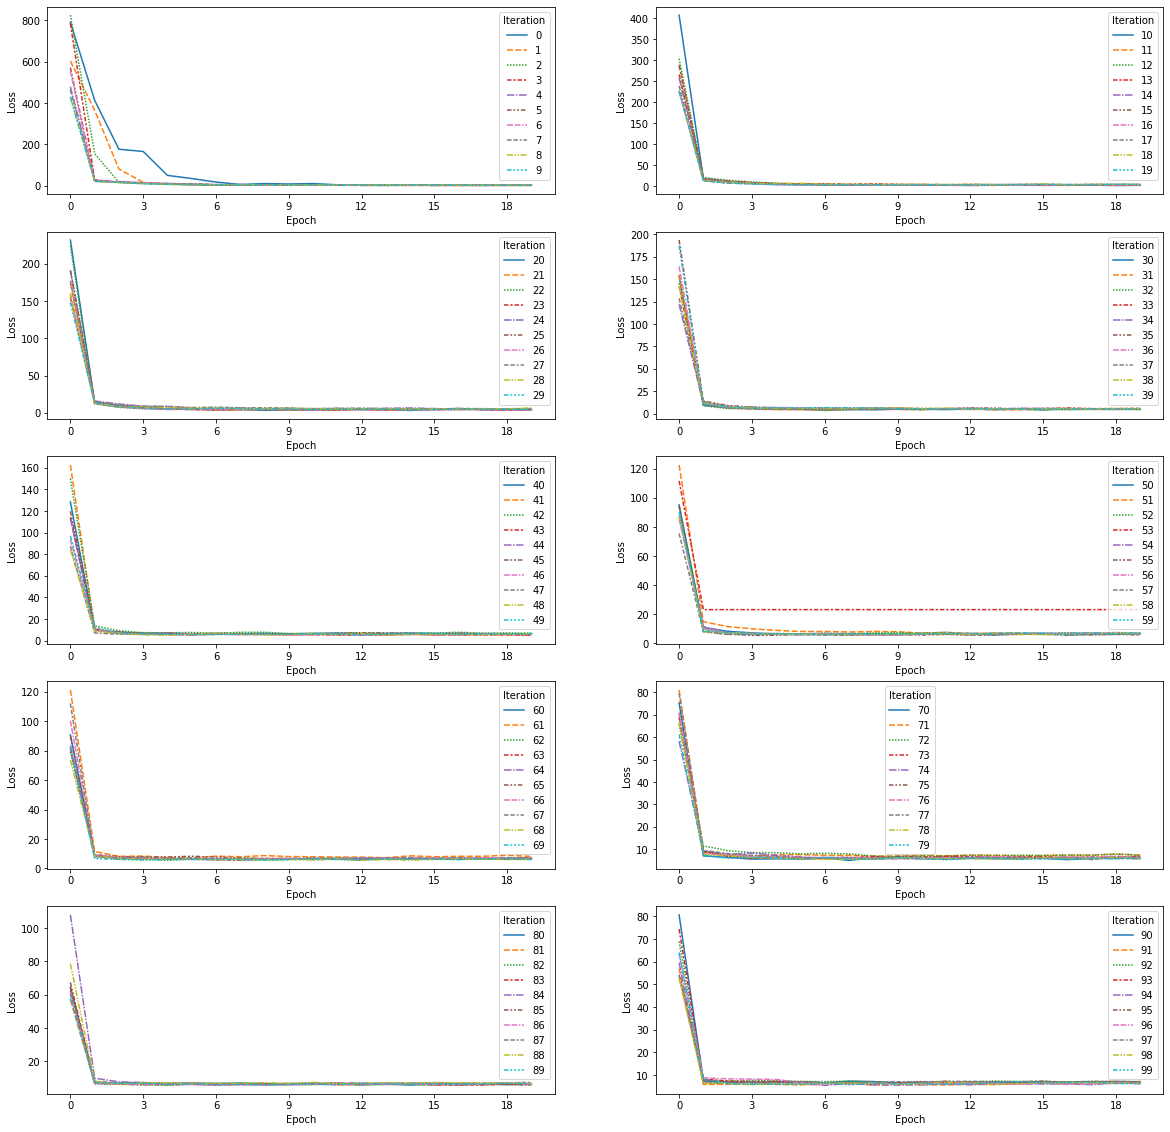

In [15]:
losses = get_losses(df_random)
loss_in_steps(losses, 10, 10, num_columns=2, to_epoch=20, figsize=(20, 20))

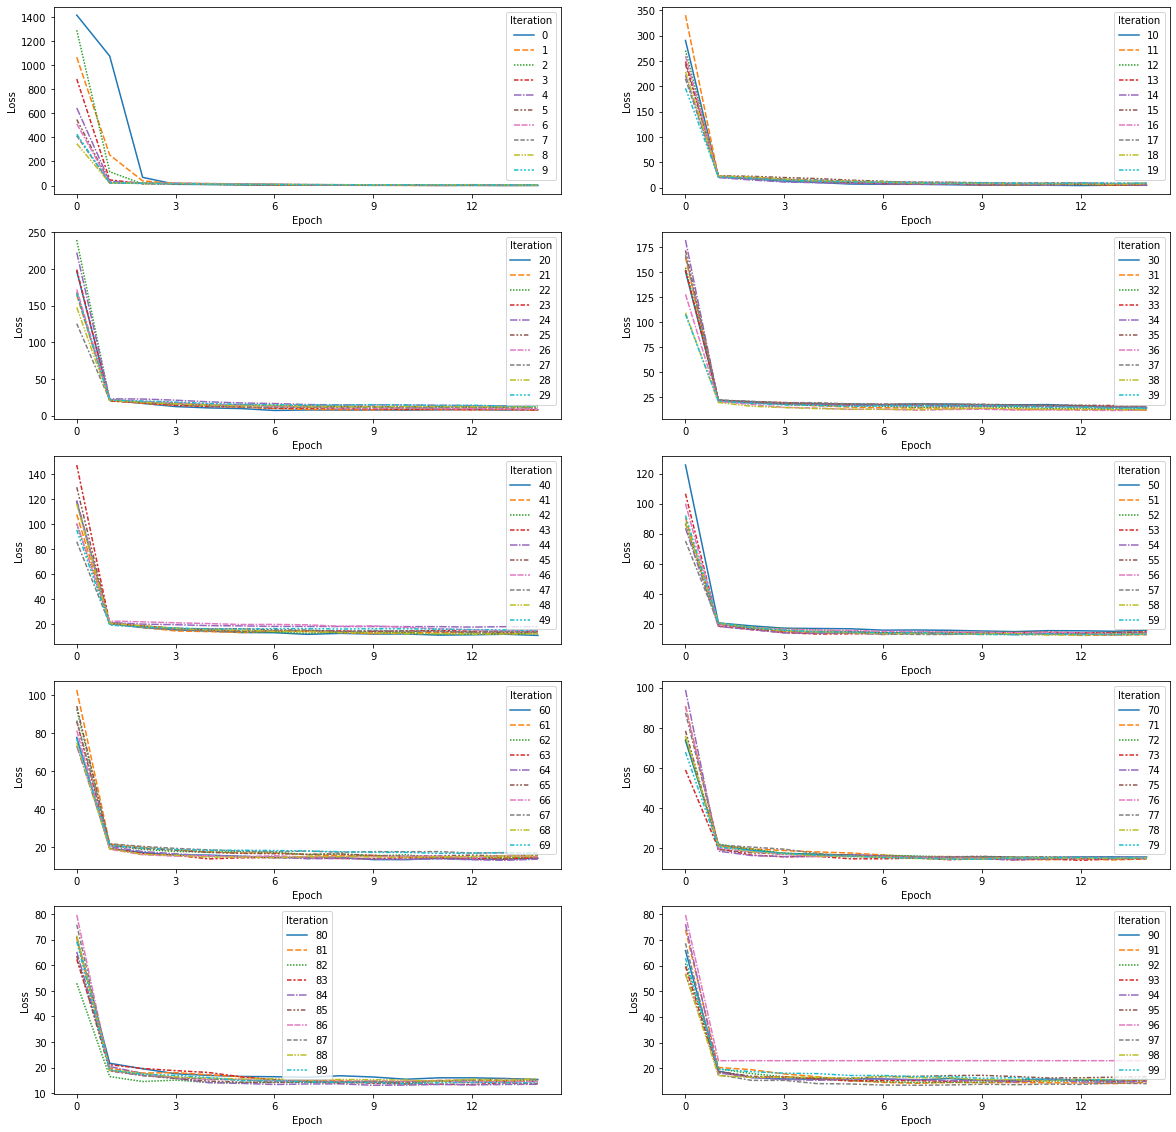

In [16]:
losses = get_losses(df_max_entropy)
loss_in_steps(losses, 10, 10, num_columns=2, to_epoch=15, figsize=(20, 20))

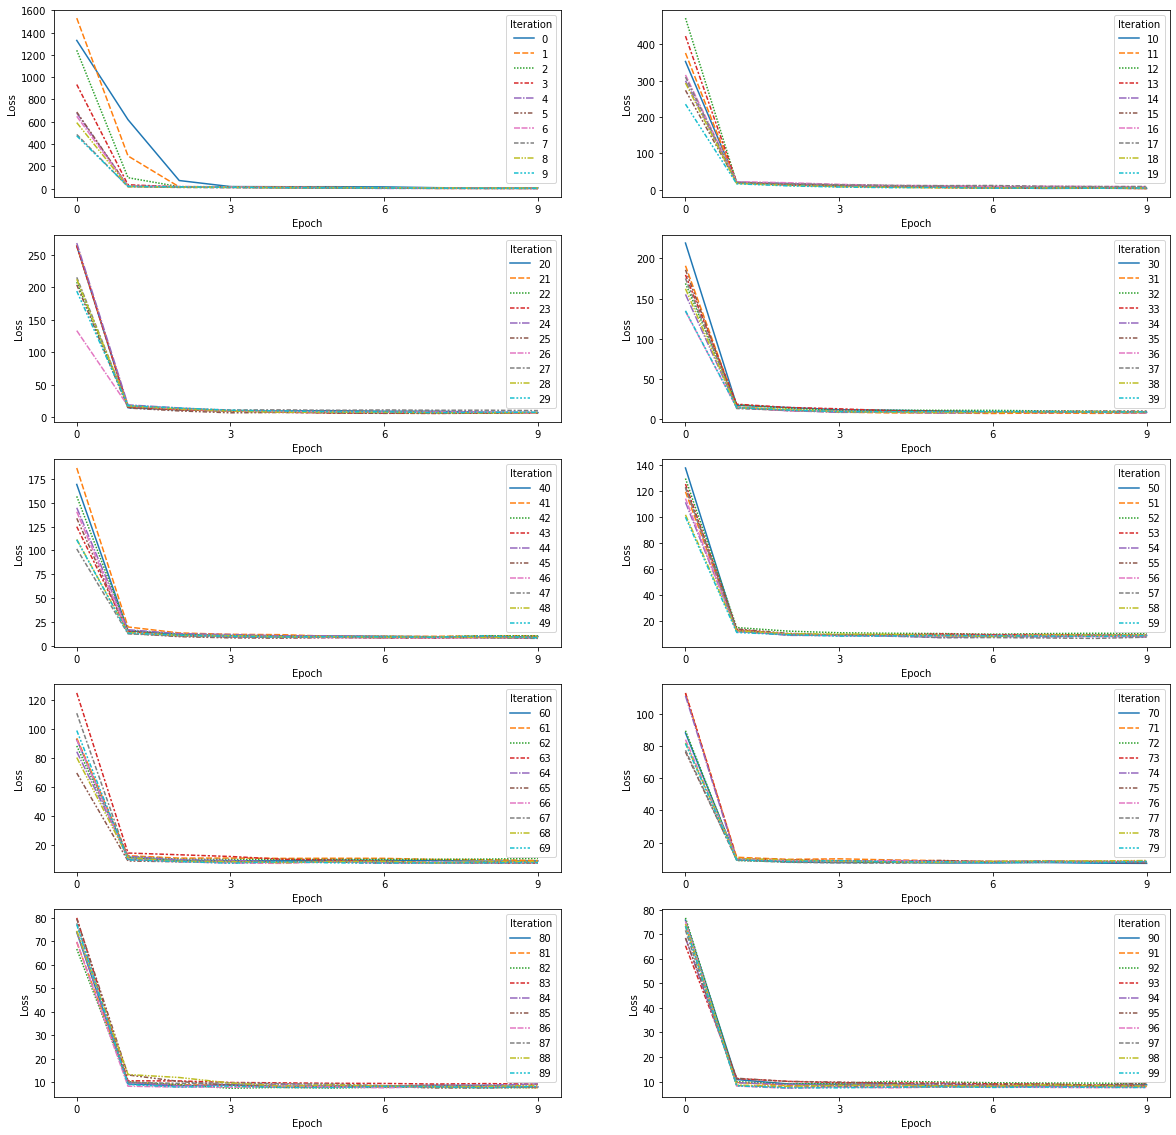

In [17]:
losses = get_losses(df_bald)
loss_in_steps(losses, 10, 10, num_columns=2, to_epoch=10, figsize=(20, 20))

# Comparison between methods

In [19]:
df_bald.insert(0, "method", "Bald")
df_max_entropy.insert(0, "method", "Max Entropy")
df_random.insert(0, "method", "Random")
df_max_var_ratio.insert(0, "method", "Max Var. Ratio.")
df_std_mean.insert(0, "method", "Std. Mean")

In [20]:
to_merge = [df_max_entropy, df_random, df_bald, df_max_var_ratio, df_std_mean]
merged = merge_and_exclude(to_merge, ["train_loss"])
merged.head()

,eval_accuracy,eval_loss,eval_time,iteration,labeled_pool_size,method,train_time
0,0.5248,121.699170,0.105619,1,20,Max Entropy,2.010280
1,0.5696,109.994835,0.092435,2,30,Max Entropy,2.813185
2,0.6444,88.849880,0.111395,3,40,Max Entropy,3.566674
3,0.6480,87.384390,0.092084,4,50,Max Entropy,4.538898
4,0.7020,70.366870,0.083436,5,60,Max Entropy,5.204942


Text(0, 0.5, 'Accuracy')

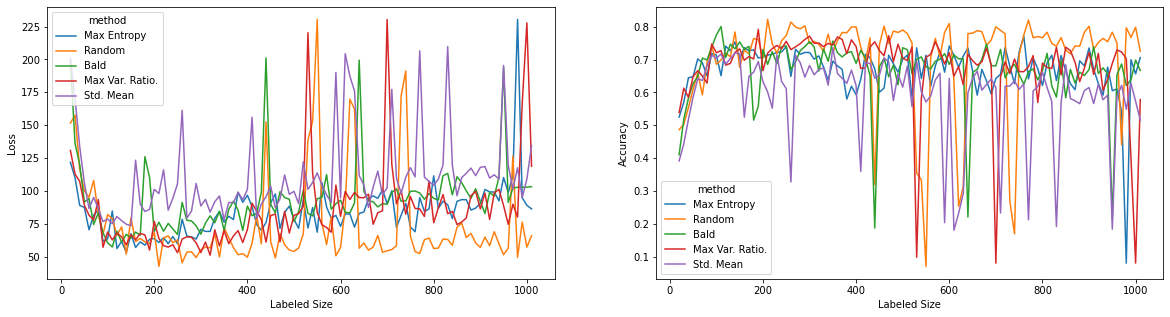

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# Query time
sns.lineplot(ax=ax[0], data=merged, x="labeled_pool_size", y="eval_loss", hue="method")
ax[0].set_xlabel("Labeled Size")
ax[0].set_ylabel("Loss")

# Accuracy
sns.lineplot(ax=ax[1], data=merged, x="labeled_pool_size", y="eval_accuracy", hue="method")
ax[1].set_xlabel("Labeled Size")
ax[1].set_ylabel("Accuracy")

# 
#sns.lineplot(ax=ax[2], data=merged, x="labeled_pool_size", y="query_time", hue="method")
#ax[2].set_xlabel("Labeled Size")
#ax[2].set_ylabel("Query Time in seconds")